# Model rainfall using a GP
based on north atlantic oscillation (NAO) and arctic oscillation (AO)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm
import math
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from sklearn.linear_model import LinearRegression

In [2]:
data_anomalies = np.load("out/data_anomalies.npy")
data_arrs = np.load("out/data_arrs.npy")
indexDf = pd.read_csv("out/indexDf.csv")

In [3]:
indexDf.head(5)

,NAO,Nino34,AO
0,1.66,25.88,0.90504
1,0.72,26.56,-0.30272
2,-0.37,26.77,-2.38600
3,-0.28,27.14,-0.28359
4,0.54,27.20,0.47918


In [4]:
data_anomalies.shape

(72, 144, 432)

### normalize anomaly time series by their standard deviation

In [6]:
for latc in range(data_anomalies.shape[0]):
    for lonc in range(data_anomalies.shape[1]):
        data_anomalies[latc,lonc,:] /= np.std(data_anomalies[latc,lonc,:])

### load the coordinates

In [7]:
base_path = "data/dataset-satellite-precipitation-b68121f1-f62e-4008-9f52-8904f47f0e7e/gpcp_v02r03_monthly_d"
arr = xr.load_dataset(base_path + "201405.nc")
lats = arr["latitude"]
lons = arr["longitude"]

In [8]:
# somewhere in scotland
lats[58].values,lons[-2].values

(array(56.25, dtype=float32), array(356.25, dtype=float32))

In [9]:
# near gibraltar
lats[50].values,lons[-2].values

(array(36.25, dtype=float32), array(356.25, dtype=float32))

In [10]:
lats[51].values,lons[-1].values

(array(38.75, dtype=float32), array(358.75, dtype=float32))

In [11]:
tseries = data_anomalies[50,-2]

## select only winter data: december, january, february

In [12]:
season = [1,2,12]

In [13]:
monthmask = np.zeros(len(tseries)).astype(bool)
for month in season:
    i = month
    while i < len(tseries):
        monthmask[i-1] = True
        i += 12
tseries = tseries[monthmask]
naoseries = indexDf.NAO[monthmask]
aoseries = indexDf.AO[monthmask]

In [14]:
all_tseries = np.zeros((lats.values.shape[0], lons.values.shape[0], len(tseries)))
for latind in range(lats.values.shape[0]):
    for lonind in range(lons.values.shape[0]):
        tseries = data_anomalies[latind,lonind].copy()
        monthmask = np.zeros(len(tseries)).astype(bool)
        for month in season:
            i = month
            while i < len(tseries):
                monthmask[i-1] = True
                i += 12
        tseries = tseries[monthmask]
        all_tseries[latind,lonind,:] = tseries
all_tseries.shape

(72, 144, 107)

### plot some winter anomaly series

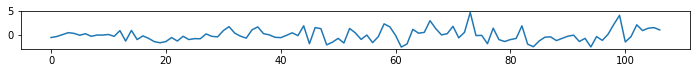

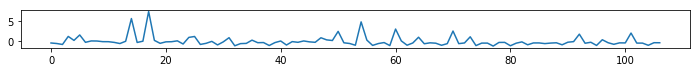

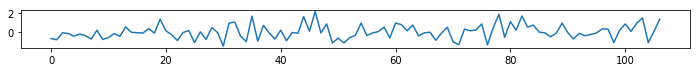

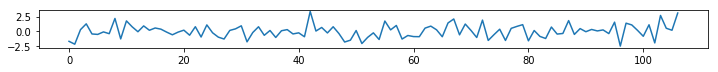

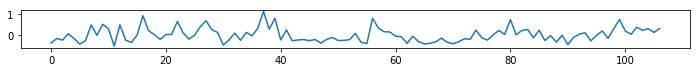

In [15]:
nt=5
for t in range(nt):
    randlat = np.random.choice(list(range(data_arrs.shape[0])))
    randlon = np.random.choice(list(range(data_arrs.shape[1])))
    plt.figure(figsize=(12,0.7))
    plt.plot(all_tseries[randlat,randlon])
    plt.show()

In [16]:
stats.pearsonr(tseries,naoseries)[0]

-0.06933313569252184

In [17]:
stats.pearsonr(tseries,aoseries)[0]

-0.10819140881425558

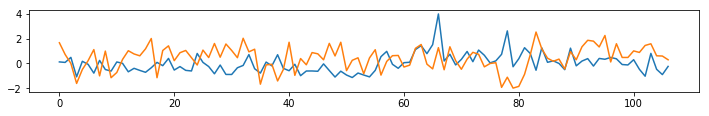

In [18]:
plt.figure(figsize=(12,1.5))
plt.plot(tseries)
plt.plot(naoseries.values)
plt.show()

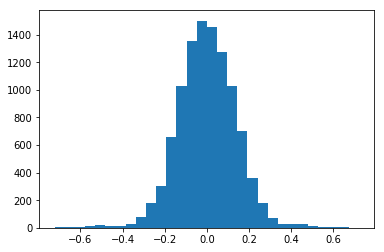

In [19]:
rs = []
for latind in range(lats.values.shape[0]):
    for lonind in range(lons.values.shape[0]):
        tseries = all_tseries[latind,lonind]
        rs.append(stats.pearsonr(tseries,naoseries)[0])
plt.figure()
plt.hist(rs,bins=30)
plt.show()

## split in training/test data

In [20]:
nsplit = 80 #len(tseries)
train_tseries = tseries[:nsplit]
test_tseries = tseries[nsplit:]
train_nao = naoseries.values[:nsplit]
test_nao = naoseries.values[nsplit:]
train_ao = aoseries.values[:nsplit]
test_ao = aoseries.values[nsplit:]

In [21]:
stats.pearsonr(train_tseries,train_nao)[0], stats.pearsonr(test_tseries,test_nao)[0]

(-0.0922272012631117, -0.0969447048945262)

In [22]:
stats.pearsonr(train_tseries,train_ao)[0], stats.pearsonr(test_tseries,test_ao)[0]

(-0.12519757207710777, -0.04551159982646473)

In [23]:
stats.pearsonr(train_nao,train_ao)[0], stats.pearsonr(test_nao,test_ao)[0]

(0.7469356741925058, 0.7025688607639523)

In [24]:
xfull = np.hstack([np.array(list(range(len(tseries)))).reshape(-1,1), naoseries.values.reshape(-1,1), aoseries.values.reshape(-1,1)])

In [25]:
x = np.hstack([np.array(list(range(len(train_tseries)))).reshape(-1,1), train_nao.reshape(-1,1), train_ao.reshape(-1,1) ])
x[-5:]

array([[ 7.5000e+01, -7.4816e-03,  7.9975e-01],
       [ 7.6000e+01,  5.6526e-02, -6.7230e-01],
       [ 7.7000e+01, -1.9257e+00, -3.4128e+00],
       [ 7.8000e+01, -1.1086e+00, -2.5868e+00],
       [ 7.9000e+01, -1.9845e+00, -4.2657e+00]])

In [26]:
x_test = nsplit+ np.array(list(range(len(test_tseries)))).reshape(-1,1)
x_test = np.hstack([x_test, test_nao.reshape(-1,1), test_ao.reshape(-1,1)])
x_test[:5]

array([[80.     , -1.8472 , -2.631  ],
       [81.     , -0.87685, -1.6831 ],
       [82.     ,  0.70124,  1.5754 ],
       [83.     ,  2.5213 ,  2.2208 ],
       [84.     ,  1.1739 , -0.21966]])

In [27]:
import theano.tensor as tt
class LinearMean(pm.gp.mean.Mean):
    R"""
    Linear mean function for Gaussian process.
    Parameters
    ----------
    coeffs: variables
        Linear coefficients
    intercept: variable, array or integer
        Intercept for linear function (Defaults to zero)
    """

    def __init__(self, coeffs, intercept=0, dim=1):
        pm.gp.mean.Mean.__init__(self)
        self.b = intercept
        self.A = coeffs
        self.dim = dim

    def __call__(self, X):
        return tt.squeeze(tt.dot(X[:,self.dim], self.A) + self.b)

In [ ]:
with pm.Model() as model:
        # TODO: this kernel seems totally useless...
        matern_length = pm.HalfNormal("matern_length", sd=5., testval=3.)
        matern_scale = pm.HalfNormal("matern_scale", sd=5., testval=3.)
        matern = matern_scale*pm.gp.cov.Matern32(1, matern_length)

        """
        tau = 20.
        c = 0.
        cov_lin_nao = tau * pm.gp.cov.Linear(2, c)
        
        tau2 = 20.
        c2 = 0.
        cov_lin_ao = tau2 * pm.gp.cov.Linear(3, c2)
        """
        
        nao_A = pm.Normal("nao_A", sd=5., testval=1.)
        nao_b = pm.Normal("nao_b", sd=5., testval=0.)
        nao_linmean = LinearMean(nao_A, intercept=nao_b, dim=1)
        
        ao_A = pm.Normal("ao_A", sd=5., testval=1.)
        ao_b = pm.Normal("ao_b", sd=5., testval=0.)
        ao_linmean = LinearMean(ao_A, intercept=ao_b, dim=2)
        
        linmean = nao_linmean + ao_linmean
        
        gp = pm.gp.Marginal(mean_func=linmean, cov_func=matern)
        epsilon = pm.HalfNormal("epsilon", sd=2., testval=0.5)
        cov_noise = pm.gp.cov.WhiteNoise(epsilon)
        y_ = gp.marginal_likelihood("y", X=x, y=train_tseries, noise=cov_noise)
            
        mp = pm.find_MAP()

In [110]:
mp

{'matern_length_log__': array(1.72482234),
 'matern_scale_log__': array(-1.42842262),
 'nao_A': array(0.08404694),
 'nao_b': array(-0.01848636),
 'ao_A': array(-0.0765424),
 'ao_b': array(-0.01848636),
 'epsilon_log__': array(-0.4667253),
 'matern_length': array(5.61152401),
 'matern_scale': array(0.2396867),
 'epsilon': array(0.62705232)}

In [111]:
mu, var = gp.predict(x_test, point=mp, diag=True)

D:\Programme\Anaconda3\envs\PyMC3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
D:\Programme\Anaconda3\envs\PyMC3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [112]:
# prediction error
((mu-test_tseries)**2).sum()

8.638676781076281

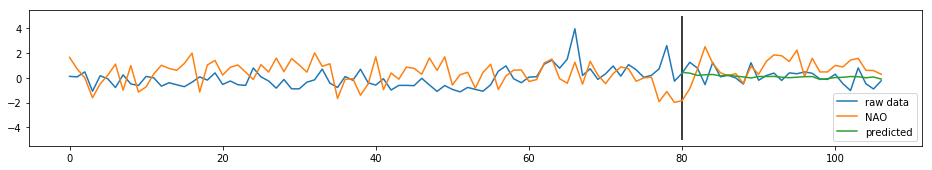

In [113]:
plt.figure(figsize=(16,2.5))
plt.plot(tseries,label="raw data")
plt.plot(naoseries.values, label="NAO")
plt.vlines(x=nsplit,ymin=-5.,ymax=5.)
plt.plot(x_test[:,0],mu,label="predicted")
plt.legend()
plt.show()

## spatial GP: linear regression where coefficients come from a spatial RBF kernel

In [29]:
lons_mask_europe = np.logical_or(lons > 340., lons < 30.)
lons_europe = lons[lons_mask_europe]
lats_mask_europe = np.logical_and(lats > 30., lats < 70.)
lats_europe = lats[lats_mask_europe]
lons_europe.values,lats_europe.values

(array([  1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,
         21.25,  23.75,  26.25,  28.75, 341.25, 343.75, 346.25, 348.75,
        351.25, 353.75, 356.25, 358.75], dtype=float32),
 array([31.25, 33.75, 36.25, 38.75, 41.25, 43.75, 46.25, 48.75, 51.25,
        53.75, 56.25, 58.75, 61.25, 63.75, 66.25, 68.75], dtype=float32))

In [30]:
def plot_map(data, title=None, europe=True, data_europe=None, vmin=None, vmax=None):
    data, lons_ = add_cyclic_point(data, coord=lons)
    fig = plt.figure(figsize=(12, 6))
    cm = 0.
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=cm))

    if europe:
        minlon = -15. + cm
        maxlon = +30. + cm
        ax.set_extent([minlon, maxlon, 35., 70.], ccrs.PlateCarree())
    
    if europe and data_europe is not None:
        vmin = np.min(data_europe)
        vmax = np.max(data_europe)
        
    ax.coastlines()
    ax.set_title(title)
    im = ax.pcolormesh(lons_, lats, data, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, pad=0.01)
    plt.show()
    
def plot_map_eur(data_europe, title=None):
    dummy = np.zeros((data_anomalies.shape[0],data_anomalies.shape[1]))
    eur_data = np.array(data_europe).reshape(lats_europe.shape[0],lons_europe.shape[0])
    a = dummy[lats_mask_europe]
    a[:,lons_mask_europe] = eur_data
    dummy[lats_mask_europe] = a
    return plot_map(dummy, data_europe=eur_data, title=title)

In [31]:
len(lats_europe.values),len(lons_europe.values)

(16, 20)

In [32]:
data_europe = all_tseries[lats_mask_europe][:,lons_mask_europe]
data_europe.shape

(16, 20, 107)

In [33]:
len_europe = data_europe.shape[0] * data_europe.shape[1]
len_europe

320

### first: a simple linear regression, where all grid points are treated independently

In [ ]:
with pm.Model() as model:
        b = pm.Normal("b", mu=0., sd=5., testval=0.5, shape=len_europe)
        A = pm.Normal("A", mu=0., sd=5., shape=len_europe)
        
        epsilon = pm.HalfNormal("epsilon", sd=0.2, testval=0.1, shape=len_europe)
        
        ys = []
        i = 0
        for latc in range(lats_europe.values.shape[0]):
            for lonc in range(lons_europe.values.shape[0]):
                y_mean = b[i] + A[i]*train_nao
                train_anomalies = data_europe[latc,lonc,:nsplit]
                y = pm.Normal("y_%s"%i, mu=y_mean, sd=epsilon[i], observed=train_anomalies)
                ys.append(y)
                i += 1
        
        mp = pm.find_MAP()

In [ ]:
mp

In [119]:
np.min(mp['A']),np.max(mp['A'])

(-1.0502092915910783, 1.045448257694551)

In [120]:
np.min(mp['b']),np.max(mp['b'])

(-0.45347660286430475, 0.4550366951079862)

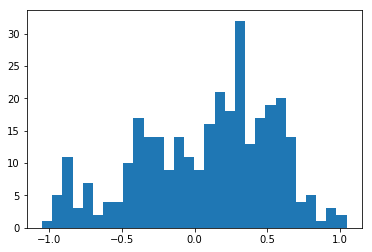

In [121]:
plt.figure()
plt.hist(mp['A'],bins=30);

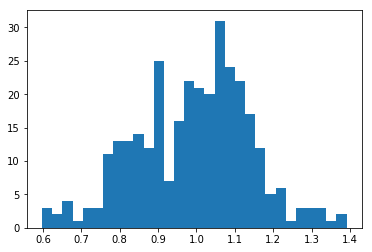

In [122]:
plt.figure()
plt.hist(mp['epsilon'],bins=30);

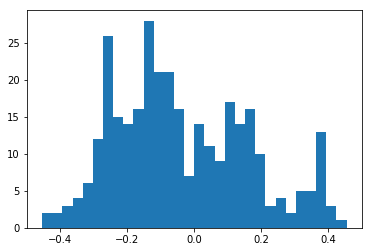

In [123]:
plt.figure()
plt.hist(mp['b'],bins=30);

### regression the non-bayesian way:

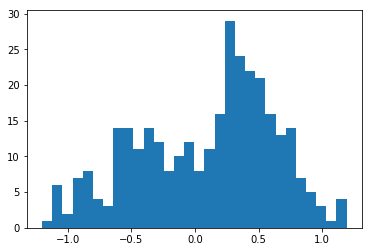

In [136]:
coeffs = []
corrs = []
for latc in range(lats_europe.values.shape[0]):
    for lonc in range(lons_europe.values.shape[0]):
        train_anomalies = data_europe[latc,lonc,:nsplit]
        reg = LinearRegression().fit(train_nao.reshape(-1,1), train_anomalies)
        corrs.append(stats.spearmanr(train_nao, train_anomalies)[0])
        coeffs.append(float(reg.coef_))
plt.figure()
plt.hist(coeffs,bins=30)
plt.show()

### plot the resulting coefficients

In [137]:
prod_europe = []
for latc in lats_europe.values:
    for lonc in lons_europe.values:
        prod_europe.append(np.array([latc,lonc]))
prod_europe = np.vstack(prod_europe)
prod_europe.shape

(320, 2)

In [138]:
np.max(coeffs)

1.1914789440361915

In [139]:
np.max(corrs)

0.765124743930503

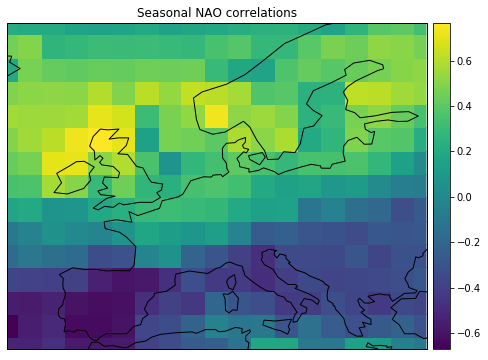

In [140]:
plot_map_eur(corrs, title="Seasonal NAO correlations")

#### evaluate predictions

In [159]:
errors = 0.
for latc in range(lats_europe.values.shape[0]):
    for lonc in range(lons_europe.values.shape[0]):
        train_anomalies = data_europe[latc,lonc,:nsplit]
        reg = LinearRegression().fit(train_nao.reshape(-1,1), train_anomalies)
        preds = reg.predict(test_nao.reshape(-1,1))
        error = ((preds-test_nao)**2).sum()
        errors += error
avg_error = errors / len_europe
print("Average prediction error: %s" % avg_error)

Average prediction error: 40.929943277449965


## now the full spatial model

In [160]:
prod_europe[:5]

array([[31.25,  1.25],
       [31.25,  3.75],
       [31.25,  6.25],
       [31.25,  8.75],
       [31.25, 11.25]], dtype=float32)

In [161]:
R = 1 # lets work with the unit sphere for now
xs = []; ys = []; zs = [];
for row in prod_europe:
    xs.append(R * math.cos(math.radians(row[0])) * math.cos(math.radians(row[1])))
    ys.append(R * math.cos(math.radians(row[0])) * math.sin(math.radians(row[1])))
    zs.append(R * math.sin(math.radians(row[0])))
prod_europe_3d = np.hstack([np.array(xs).reshape(-1,1),np.array(ys).reshape(-1,1),np.array(zs).reshape(-1,1)])
prod_europe_3d.shape

(320, 3)

In [162]:
prod_europe_3d[:5]

array([[0.85470842, 0.0186498 , 0.51877326],
       [0.85308144, 0.05591391, 0.51877326],
       [0.84983056, 0.09307158, 0.51877326],
       [0.84496199, 0.13005209, 0.51877326],
       [0.83848498, 0.16678503, 0.51877326]])

In [ ]:
with pm.Model() as model:
        # TODO: should this come from a GP, too?
        b = pm.Normal("b", sd=5., testval=0.5, shape=len_europe)
        matern_length = 0.001 + pm.HalfNormal("matern_length", sd=2., testval=0.3)
        matern_scale = 0.001 + pm.HalfNormal("matern_scale", sd=5., testval=3.)
        matern = matern_scale*pm.gp.cov.Matern52(input_dim=3, ls=matern_length, active_dims=[0,1,2])
        gp = pm.gp.Latent(cov_func=matern)
        f = gp.prior("f", X=prod_europe_3d)
        
        A = f# pm.Normal("A", sd=5., shape=len_europe)
        
        epsilon = 0.001 + pm.HalfNormal("epsilon", sd=0.2, testval=0.1, shape=len_europe)
        
        ys = []
        i = 0
        for latc in range(lats_europe.values.shape[0]):
            for lonc in range(lons_europe.values.shape[0]):
                y_mean = b[i] + A[i]*train_nao
                train_anomalies = data_europe[latc,lonc,:nsplit]
                y = pm.Normal("y_%s"%i, mu=y_mean, sd=epsilon[i], observed=train_anomalies)
                ys.append(y)
                i += 1
        
        mp = pm.find_MAP()

D:\Programme\Anaconda3\envs\PyMC3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
D:\Programme\Anaconda3\envs\PyMC3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [ ]:
mp['matern_length']

In [ ]:
mp['matern_scale']

In [ ]:
mp['f'].shape

In [ ]:
plt.figure()
plt.hist(mp['f'],bins=30);

In [ ]:
plt.figure()
plt.hist(mp['b'],bins=30);

In [ ]:
plt.figure()
plt.hist(mp['epsilon'],bins=30);

In [ ]:
# TODO: look at b
plot_map_eur(mp['b'], title="b")

In [ ]:
plot_map_eur(mp['f'], title="Seasonal NAO correlations")

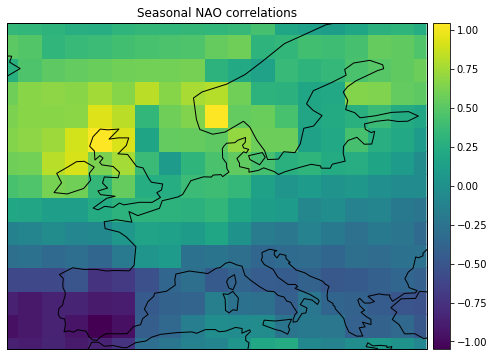

In [40]:
plot_map_eur(mp['f'], title="Seasonal NAO correlations")

## seasonal model where the GP includes a spatial and monthly component

In [ ]:
# replicate this for each month
prod_europe_3d

In [ ]:
with pm.Model() as model:
        # TODO: should this come from a GP, too?
        b = pm.Normal("b", sd=5., testval=0.5, shape=len_europe)
        matern_length = pm.HalfNormal("matern_length", sd=2., testval=0.5)
        matern_scale = pm.HalfNormal("matern_scale", sd=5., testval=3.)
        matern = matern_scale*pm.gp.cov.Matern52(input_dim=3, ls=matern_length, active_dims=[0,1,2])
        
        rbf_length = pm.HalfNormal("rbf_length", sd=2., testval=0.5)
        rbf_scale = pm.HalfNormal("rbf_scale", sd=5., testval=3.)
        rbf_month = rbf_scale*pm.gp.cov.RBF(input_dim=1, ls=rbf_length, active_dims=[3])
        
        gp = pm.gp.Latent(cov_func=matern)
        f = gp.prior("f", X=prod_europe_3d)
        
        mp = pm.find_MAP()